## CNN that predicts angle

A simple CNN with one output - a number represents angle of rotation. 

We use this angle to rotate picture back. As a visual indicator of rotation we use drawn rectangles.

In [1]:
import cv2
import random
import pandas as pd
import matplotlib.image as mpimg
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import load_model
from keras.models import Sequential
from keras.layers import Lambda, Dense, Flatten, Dropout
from keras.layers import Conv2D, Activation, ELU
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# constants
SIZE = 64
BATCH_SIZE = 64

In [3]:
# read csv logs
rows = pd.read_csv('datalog_train_simple.csv')
angles = rows['angle'].tolist()
samples = rows['image'].tolist()
print("Number of training samples: ", len(angles))

Number of training samples:  2600


In [4]:
# split
shuffle(samples, angles)
imgs_train, imgs_valid, angles_train, angles_valid = train_test_split(samples, angles, test_size=0.3)

In [5]:
# data preprocessing pipeline
def resize(img):
    return cv2.resize(img, (SIZE, SIZE))

def random_shift(img):
    if random.randint(0, 1) == 0:
        return img
    h, w, c = img.shape
    shape = (w, h)
    M = np.float32([[1, 0, random.randint(-SIZE // 7, SIZE // 7)],
                    [0, 1, random.randint(-SIZE // 9, SIZE // 9)]])
    return cv2.warpAffine(img, M, shape)

def flip(img, angle):
    if random.randint(0, 1) == 0:
        return img, angle
    img = np.fliplr(img)
    angle = -angle
    return img, angle

In [6]:
# generators
def train_generator(batch_size):
    while True:  # Loop forever so the generator never terminates
        shuffle(imgs_train, angles_train)
        batch_imgs = []
        batch_angles = []
        for i in range(batch_size):
            random_index = random.randint(0,len(imgs_train)-1)
            angle = angles_train[random_index] * (1 + random.uniform(-0.1, 0.1)) # add noise
            img = mpimg.imread(imgs_train[random_index])
            img = random_shift(img)
            img, angle = flip(img, angle)
            img = resize(img)
            batch_imgs.append(img)
            batch_angles.append(angle)
        yield (np.array(batch_imgs), np.array(batch_angles))


def valid_generator(batch_size):
    while True:  # Loop forever so the generator never terminates
        shuffle(imgs_valid, angles_valid)
        batch_imgs = []
        batch_angles = []
        for i in range(batch_size):
            random_index = random.randint(0,len(imgs_valid)-1)
            angle = angles_valid[random_index]
            img = mpimg.imread(imgs_valid[random_index])
            img = resize(img)
            batch_imgs.append(img)
            batch_angles.append(angle)
        yield (np.array(batch_imgs), np.array(batch_angles))

# generate
generator_train = train_generator(BATCH_SIZE)
generator_valid = valid_generator(BATCH_SIZE)

In [7]:
# parameters
steps_per_epoch = len(imgs_train) // BATCH_SIZE
val_steps = len(imgs_valid) // BATCH_SIZE
shape = (SIZE, SIZE, 3)

In [8]:
# network architecture
def guess_angle():
    model = Sequential()
    model.add(Lambda(lambda x: (x / 250) - 0.5, input_shape=shape))

    model.add(Conv2D(24, (5, 5), strides=(2, 2), padding="valid", 
                     kernel_initializer="he_normal"))
    
    model.add(Flatten())

    model.add(Dense(100, kernel_initializer='he_normal'))
    model.add(ELU())
    
    model.add(Dense(1))
    return model

In [9]:
model = guess_angle()

# train and save
adam = Adam(lr=0.001)

import keras.backend as K
def scheduler(epoch):
    if epoch == 0:
        print("learning rate:", K.get_value(model.optimizer.lr))
    if (epoch+1) % 10 == 0:
        rate = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, rate * 0.3)
        print("learning rate:", K.get_value(model.optimizer.lr))
    return K.get_value(model.optimizer.lr)

learning_rate_decay = LearningRateScheduler(scheduler)
early_stop = EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint('model_simple.h5', monitor='val_loss', save_best_only=True)

model.compile(loss='mse', optimizer=adam)
model.summary()

history = model.fit_generator(generator_train,
                    steps_per_epoch=steps_per_epoch,
                    epochs=10,
                    validation_data=generator_valid,
                    validation_steps=val_steps, 
                    callbacks=[checkpoint, early_stop, learning_rate_decay])

model.save('model_simple.h5')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 24)        1824      
_________________________________________________________________
flatten_1 (Flatten)          (None, 21600)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               2160100   
_________________________________________________________________
elu_1 (ELU)                  (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 2,162,025
Trainable params: 2,162,025
Non-trainable params: 0
_________________________________________________________________


## Evaluate model

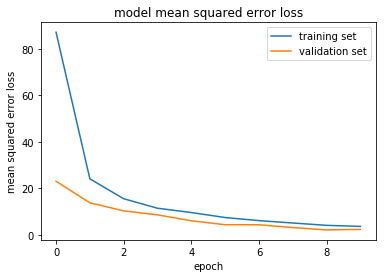

In [10]:
# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [11]:
# read csv logs
rows_test = pd.read_csv('datalog_test_simple.csv')
angles_test = rows_test['angle'].tolist()
samples_test = rows_test['image'].tolist()
print("Number of test samples: ", len(samples_test))

Number of test samples:  500


In [12]:
# evaluate on test data
img_test = []
ang_test = []

for i in range(len(samples_test)-1):
    angle = angles_test[i]
    img = mpimg.imread(samples_test[i])
    img = resize(img)
    img_test.append(img)
    ang_test.append(angle)
    
score = model.evaluate(np.array(img_test), np.array(ang_test), verbose=0)
print("Average error: ±{0:.2f}".format(np.sqrt(score)))

Average error: ±1.76


Actual angle:  -5


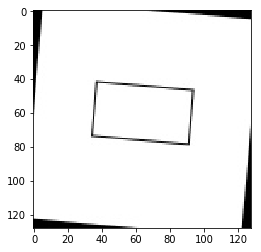

In [13]:
# example: one test image that we want to correct
random.seed(10)
random_index = random.randint(0,len(samples_test)-1)
angle = angles_test[random_index]
img = mpimg.imread(samples_test[random_index])
plt.imshow(img)
print("Actual angle: ", angle)

In [14]:
# predict angle
image = resize(img)
image_array = np.asarray(image)
ang = float(model.predict(image_array[None, :, :, :], batch_size=1))
print("Predicted angle: ", ang)

Predicted angle:  -5.23566198348999


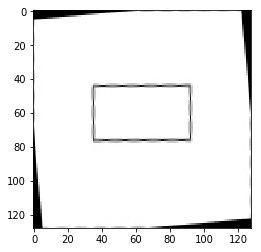

In [15]:
# angle correction
height, width, ch = img.shape
sh = (width, height)
center = (width // 2, height // 2)
M = cv2.getRotationMatrix2D(center, -ang, 1.0)
result = cv2.warpAffine(img, M, sh)
plt.imshow(result)
plt.show()